# Causal Inference and Predictive Modeling of Housing Prices  
### *A Comparative Study Using 2SLS, Linear Regression, and Neural Networks*

> Exploring both structural relationships and predictive performance across econometric and machine learning methods.


## Introduction

Understanding the dynamics behind housing prices is essential for policymakers, investors, and economists alike.  
This study explores both the **causal relationships** and **predictive performance** of various factors affecting housing prices in Canada from **1988 to 2020**.

Using a **two-stage least squares (2SLS)** approach, I first investigate how **interest rates influence credit volume**, and in turn, how **credit affects housing prices**.

Beyond causal analysis, I compare traditional **linear regression** , **neural network models**,**lasso** and **desision trees** to compare how well these methods can forecast housing prices.

By combining **econometric techniques** with **machine learning**, this research aims to bridge the gap between **interpretation** and **prediction**, providing a more complete picture of what drives changes in the housing market.


## Source of data
All the data sets comes from **Statistics Canada**

| File Name                     | Source Link                                                                                                                   | Description                                                                                                                     |
|------------------------------|--------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------|
| `CPI.csv`                    | [Link](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810000401)                                                      | Consumer Price Index, monthly, not seasonally adjusted                                                                          |
| `houseindex.csv`             | [Link](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810020501)                                                      | New housing price index, monthly                                                                                                |
| `mortgagecredit.csv`         | [Link](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1010012901)                                                      | Residential mortgage credit (in millions), outstanding balances from major private lenders, Bank of Canada                     |
| `unemplyed.csv`              | [Link](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1410002101)                                                      | Unemployment, participation, and employment rates by type of student, monthly, unadjusted for seasonality                      |
| `mortgagerate.csv`           | [Link](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3410014501)                                                      | CMHC, conventional mortgage lending rate, 5-year term                                                                           |
| `newhomes.csv`, `newcondos.csv` | [Link](https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=3410015201)                                                  | CMHC housing starts by dwelling type and market type in centres with 50,000+ population, for Canada and provinces              |


### 1. Import library

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import seaborn as sns


In [26]:
CPI_D = pd.read_csv('CPI.csv',encoding='utf-8-sig')
HOUSE_INDEX = pd.read_csv('houseindex.csv',encoding='utf-8-sig')
MORTAGECREDIT = pd.read_csv('mortgagecredit.csv',encoding='utf-8-sig')
MORTAGERATE = pd.read_csv('mortgagerate.csv',encoding='utf-8-sig')
NEW_HOME_SALES = pd.read_csv('newhomes.csv',encoding='utf-8-sig')
NEW_CONDOS = pd.read_csv('newcondos.csv',encoding='utf-8-sig')
UNEMPLOYED = pd.read_csv('unemplyed.csv',encoding='utf-8-sig')


In [27]:
df = pd.merge(CPI_D, HOUSE_INDEX, on='REF_DATE', how='outer')  
df = pd.merge(df, MORTAGECREDIT, on='REF_DATE', how='outer') 
df = pd.merge(df, MORTAGERATE, on='REF_DATE', how='outer')  
df = pd.merge(df, NEW_HOME_SALES, on='REF_DATE', how='outer')  
df = pd.merge(df, NEW_CONDOS, on='REF_DATE', how='outer') 
df = pd.merge(df, UNEMPLOYED, on='REF_DATE', how='outer')
df['REF_DATE'] = pd.to_datetime(df['REF_DATE']) 
df['TimeTrend'] = np.arange(1, len(df) + 1)
df['CPI_growth'] = df['CPI'].diff()
df['CREDIT'] = df['CREDIT'] / 10000 #Now the unit is 10 billion CAD
df['CREDIT_growth'] = df['CREDIT'].diff()
df = df.dropna()  
df['TimeTrend'] = df['TimeTrend'] - 394




## Data overview

In [28]:
df

,REF_DATE,CPI,HINDEX,CREDIT,MRATE,HNUM,CNUM,URATE,TimeTrend,CPI_growth,CREDIT_growth
394,1988-11-01,72.3,55.0,19.2308,11.78,8318.0,3844.0,10.2,1,0.1,0.2018
395,1988-12-01,72.3,55.8,19.4579,12.13,7249.0,2670.0,9.8,2,0.0,0.2271
396,1989-01-01,72.7,56.3,19.6837,12.24,5990.0,4667.0,11.3,3,0.4,0.2258
397,1989-02-01,73.2,57.7,19.9273,12.23,5024.0,2137.0,11.1,4,0.5,0.2436
398,1989-03-01,73.6,58.6,20.1617,12.41,6423.0,3310.0,11.0,5,0.4,0.2344
...,...,...,...,...,...,...,...,...,...,...,...
768,2020-01-01,136.8,103.4,164.0113,4.08,4000.0,2806.0,8.8,375,0.4,0.6015
769,2020-02-01,137.4,103.8,164.4740,4.08,4302.0,4021.0,8.9,376,0.6,0.4627
770,2020-03-01,136.6,104.1,165.2870,3.90,4655.0,4196.0,15.1,377,-0.8,0.8130
771,2020-04-01,135.7,104.1,166.2719,3.95,3603.0,5444.0,22.6,378,-0.9,0.9849


### Description of variables

| Variable    | Description                          |
|-------------|--------------------------------------|
| REF_DATE    | Observation date (YYYY-MM-DD)        |
| CPI         | Consumer Price Index (inflation)     |
| HINDEX      | Housing market index (target)        |
| CREDIT      | Total housing credit available  (unit is 10 billion CAD)     |
| MRATE       | Mortgage interest rate (%)           |
| HNUM        | Number of new homes                  |
| CNUM        | Number of new condos                 |
| URATE       | Unemployment rate (%)                |
| TimeTrend   | Monthly counter (1 = Nov 1988)       |

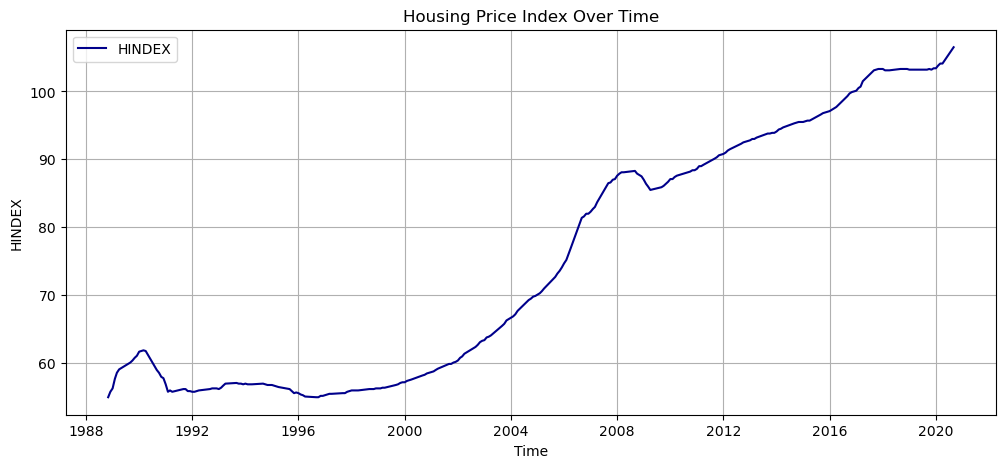

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df["REF_DATE"], df["HINDEX"], label="HINDEX", color="darkblue")
plt.title("Housing Price Index Over Time")
plt.xlabel("Time")
plt.ylabel("HINDEX")
plt.grid(True)
plt.legend()
plt.show()


In [30]:
df['SubprimeCrisis'] = (
    (df['REF_DATE'] >= '2006-06-01') & (df['REF_DATE'] <= '2009-06-30')
).astype(int)



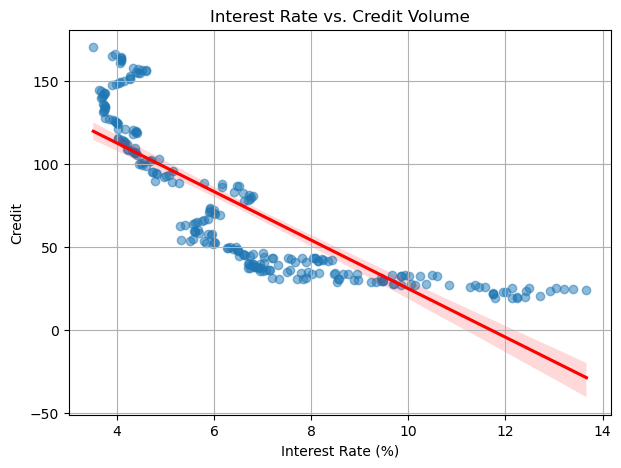

In [31]:
plt.figure(figsize=(7, 5))
sns.regplot(x="MRATE", y="CREDIT", data=df, scatter_kws={"alpha": 0.5},line_kws={"color": "red"})
plt.title("Interest Rate vs. Credit Volume")
plt.xlabel("Interest Rate (%)")
plt.ylabel("Credit")
plt.grid(True)
plt.show()


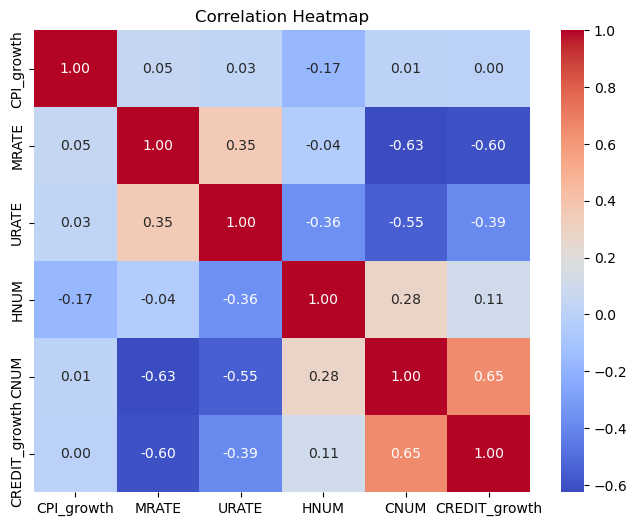

In [32]:
plt.figure(figsize=(8, 6))
corr = df[[ "CPI_growth", "MRATE", "URATE", "HNUM", "CNUM","CREDIT_growth"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


## Use interest rate as an instrument to predict housing price via credit (Two-Stage Least Squares)

---

### First Stage  
Use the instrument (interest rate) to predict the endogenous variable (credit):

$$
\text{CREDIT}_t = \alpha_0 + \alpha_1 \cdot \text{MRATE}_t + \alpha_2 \cdot \text{Controls}_t + \alpha_3 \cdot \text{TimeTrend}_t + u_t
$$

- **Endogenous variable**: `CREDIT`
- **Instrumental variable**: `MRATE` (interest rate)
- **Control variables**: e.g., `URATE`, `HNUM`, `CPI`, `CNUM`, etc.
- **Time trend**: added to account for structural shifts over time

---

### Second Stage  
Use the predicted credit from stage one to estimate the housing price index:

$$
\text{HINDEX}_t = \beta_0 + \beta_1 \cdot \hat{\text{CREDIT}}_t + \beta_2 \cdot \text{Controls}_t + \beta_3 \cdot \text{TimeTrend}_t + \varepsilon_t
$$

- **Dependent variable (Y)**: `HINDEX` (housing price index)
- **$\hat{\text{CREDIT}}$**: fitted values from the first stage regression

---




### Causal Impact of Credit Volume on Housing Prices

To explore the causal impact of credit volume on housing prices, this study adopts the **Two-Stage Least Squares (2SLS)** approach. The motivation for using this method is due to the likely **endogeneity** of credit volume (CREDIT) in the housing price equation. This means that credit volume might be influenced by unobserved factors that also affect housing prices. These factors could include:

- Macroeconomic shocks
- Measurement errors
- Reverse causality (e.g., rising housing prices encouraging more lending)

Because of this endogeneity, using **Ordinary Least Squares (OLS)** could lead to **biased or inconsistent estimates**. To address this issue, we use the **market interest rate (MRATE)** as an instrumental variable for CREDIT.

### Why MRATE is a good instrument for CREDIT:

1. **Relevance**: Interest rates are closely related to credit volume. As interest rates increase, borrowing becomes more expensive, which generally reduces the overall volume of credit in the economy.
  
2. **Exogeneity**: Interest rates, particularly those set through monetary policy, are largely **exogenous** to local housing prices. They affect housing indirectly through credit conditions, not directly. Therefore, MRATE meets the **exclusion restriction** — it impacts housing prices only through its effect on credit.

By using MRATE as an instrument, we can obtain more accurate estimates of the causal effect of credit volume on housing prices.


In [33]:
controls = ['URATE', 'HNUM', 'TimeTrend', 'CNUM','CPI_growth','SubprimeCrisis']
Y = 'HINDEX'
endog = 'CREDIT_growth'
instrument = 'MRATE'
control_vars = '+'.join(controls)
formula = f"{Y} ~ 1 + [{endog} ~ {instrument}] + {control_vars}"
iv_model = IV2SLS.from_formula(formula, data=df).fit(cov_type='robust')
print(iv_model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                 HINDEX   R-squared:                      0.4145
Estimator:                    IV-2SLS   Adj. R-squared:                 0.3979
No. Observations:                 255   F-statistic:                    517.64
Date:                Sun, May 11 2025   P-value (F-stat)                0.0000
Time:                        17:58:40   Distribution:                  chi2(7)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                                
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
Intercept          71.125     11.436     6.2193     0.0000      48.711      93.540
URATE             -1.2536     0.6432

## I. Model valuation

| Item                     | Description |
|--------------------------|-------------|
| **R-squared**            |  0.4145 — Proportion of variance in `HINDEX` explained by the model.  0.4145 indicated my model has strong explanatory power. |
| **Adjusted R-squared**   |  0.3979 — Adjusted for the number of predictors; confirms high model fit while penalizing overfitting. |
| **F-statistic**          | 517.64 — The extremely high F-statistic indicates that the explanatory variables jointly have strong explanatory power for the dependent variable. |
| **P-value (F-stat)**     | 0.0000 — Indicates the null hypothesis (that all coefficients are zero) is strongly rejected. It shows this model is legit. |


## 2.IV-2SLS Estimation Coefficients, Significance, and Interpretation

| **Variable**       | **Coefficient** | **Significant or Not**   | **Interpretation**                                                                                                 |
|--------------------|-----------------|--------------------------|--------------------------------------------------------------------------------------------------------------------|
| **Intercept**       | 71.125          | **Significant** (p < 0.01) | The baseline value of the housing price index when all other variables are 0. Suggests a starting index value.   |
| **URATE** (Unemployment Rate) | -1.2536         | **Marginally Significant** (p ≈ 0.05) | A 1% increase in the unemployment rate is associated with a **1.25 decrease** in housing price index.                   |
| **HNUM** (Number of new homes)  | -0.0023         | **Significant** (p < 0.01) | A 1-unit increase in the number of new home on the market is associated with a **decrease of 0.0023** in the housing price index. |
| **TimeTrend**       | 0.0047          | **Not Significant** (p > 0.05) | A very small increase in the housing price index over time, but the effect is statistically insignificant.         |
| **CNUM** (Number of new condos) | -0.0007         | **Not Significant** (p > 0.05) | A 1-unit increase in the number of new condo on the market is associated with a **decrease of 0.0007** in the housing price index.    |
| **CPI_growth** (period-over-period change)  | -2.5494         | **Not Significant** (p > 0.05) | A 1-unit increase in **CPI growth** (i.e., the change in CPI) is associated with a **2.5494 decrease** in housing prices index.      |
| **SubprimeCrisis(dummy)**  | -13.267         | **Significant** (p < 0.05) | The subprime mortgage crisis is associated with a **13.267 decrease** in housing prices.                           |
| **CREDIT_growth** (period-over-period change) | 89.043      | **Significant** (p < 0.01) | A 1-unit(10 billion CAD) increase in **CREDIT_growth** (i.e., the change in CPI) is associated with a **89.043 increase** in housing prices index.  |


In [34]:
print(iv_model.first_stage)


     First Stage Estimation Results     
                           CREDIT_growth
----------------------------------------
R-squared                         0.6099
Partial R-squared                 0.0441
Shea's R-squared                  0.0441
Partial F-statistic               15.800
P-value (Partial F-stat)       7.039e-05
Partial F-stat Distn             chi2(1)
==========================   ===========
Intercept                        -0.7980
                               (-3.7547)
URATE                             0.0215
                                (2.6961)
HNUM                               2e-05
                                (3.0301)
TimeTrend                         0.0024
                                (7.1942)
CNUM                           2.577e-05
                                (2.7809)
CPI_growth                        0.0232
                                (0.7794)
SubprimeCrisis                    0.1917
                                (3.3022)
MRATE           

# Linear regression prediction

In [35]:
from sklearn import (           
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [36]:
df1 = df.copy()
X_1 = df1[[ 'CPI_growth','CREDIT_growth', 'HNUM','CNUM','URATE','TimeTrend']].values
y_1 = df1['HINDEX'].values
features = [ 'CPI_growth','CREDIT_growth','HNUM','CNUM','URATE','TimeTrend']
REF_DATE = df['REF_DATE'] 
X_train_1, X_test_1, y_train_1, y_test_1, REF_DATE_train_1, REF_DATE_test_1 = train_test_split(
    X_1, y_1, REF_DATE, test_size=0.25, random_state=44
)



In [37]:
model = linear_model.LinearRegression()
model.fit(X_train_1, y_train_1)
coefficients = pd.Series(model.coef_, index=features)
print("Coefficients:\n", coefficients)
print("Intercept:", model.intercept_)
print("R-squared:", model.score(X_test_1, y_test_1))
y_pred = model.predict(X_test_1)
print("MSE:", mean_squared_error(y_test_1, y_pred))
baseline_mse = np.mean((y_test_1 - np.mean(y_train_1))**2)
print("Baseline MSE:", baseline_mse)

Coefficients:
 CPI_growth       -0.161152
CREDIT_growth    11.921686
HNUM             -0.001327
CNUM              0.001539
URATE            -0.277515
TimeTrend         0.115701
dtype: float64
Intercept: 53.760399831297875
R-squared: 0.9372082708700418
MSE: 19.763607829584778
Baseline MSE: 324.3544254029495


In [38]:
cv_model = LinearRegression()
cv_scores =cross_val_score(cv_model, X_1, y_1, cv=10, scoring='neg_mean_squared_error')
cv_mse_scores = -cv_scores  
print("Cross-validated MSE scores:", cv_mse_scores)
print("Mean CV MSE:", -np.mean(cv_scores))


Cross-validated MSE scores: [195.79434361  16.52271666  29.24743831  61.42890046  53.00886845
  14.13553486  46.2831803   12.60291023   8.29937417  18.94675588]
Mean CV MSE: 45.62700229261623


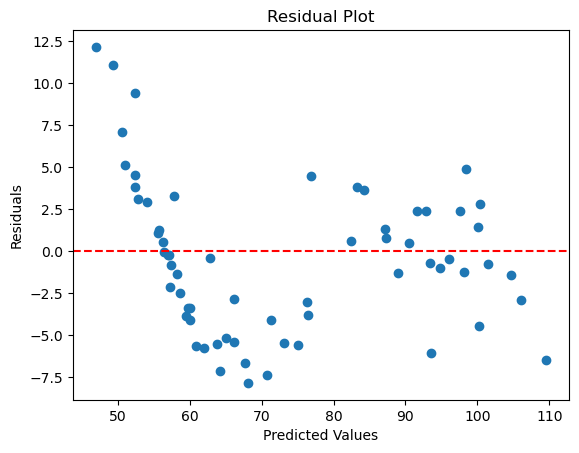

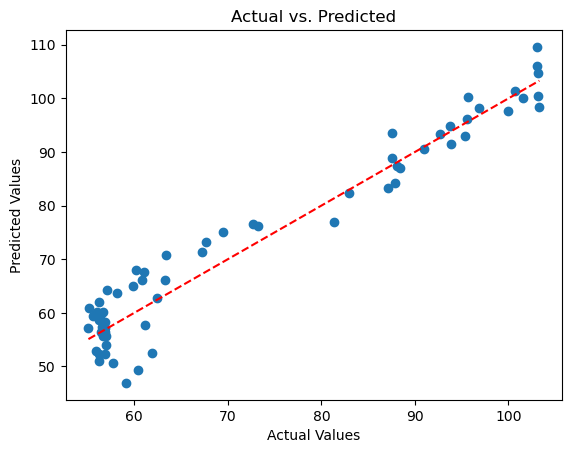

In [39]:
import matplotlib.pyplot as plt

# 1. Residual Plot
plt.scatter(y_pred, y_test_1 - y_pred)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.show()

# 2. Actual vs. Predicted
plt.scatter(y_test_1, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test_1), max(y_test_1)], [min(y_test_1), max(y_test_1)], 'r--')
plt.title("Actual vs. Predicted")
plt.show()

## Problem Discovered

The residuals are not randomly scattered around zero. There is a noticeable pattern where the residuals are large (both positive and negative) for predicted values between 50 and 70, indicating that the model is struggling to fit well in this range. This suggests the presence of something in the data that the current model cannot capture.

**This reminds me of periodic fluctuations because, if we can interpret the x-axis as "time" because of the house price index always naturally increase over time. Thus, the residuals should show an up-and-down pattern across different time periods.**

So, I decided to create a graph to directly examine if there is a relationship between time and the residuals!

And below is how it goes!!


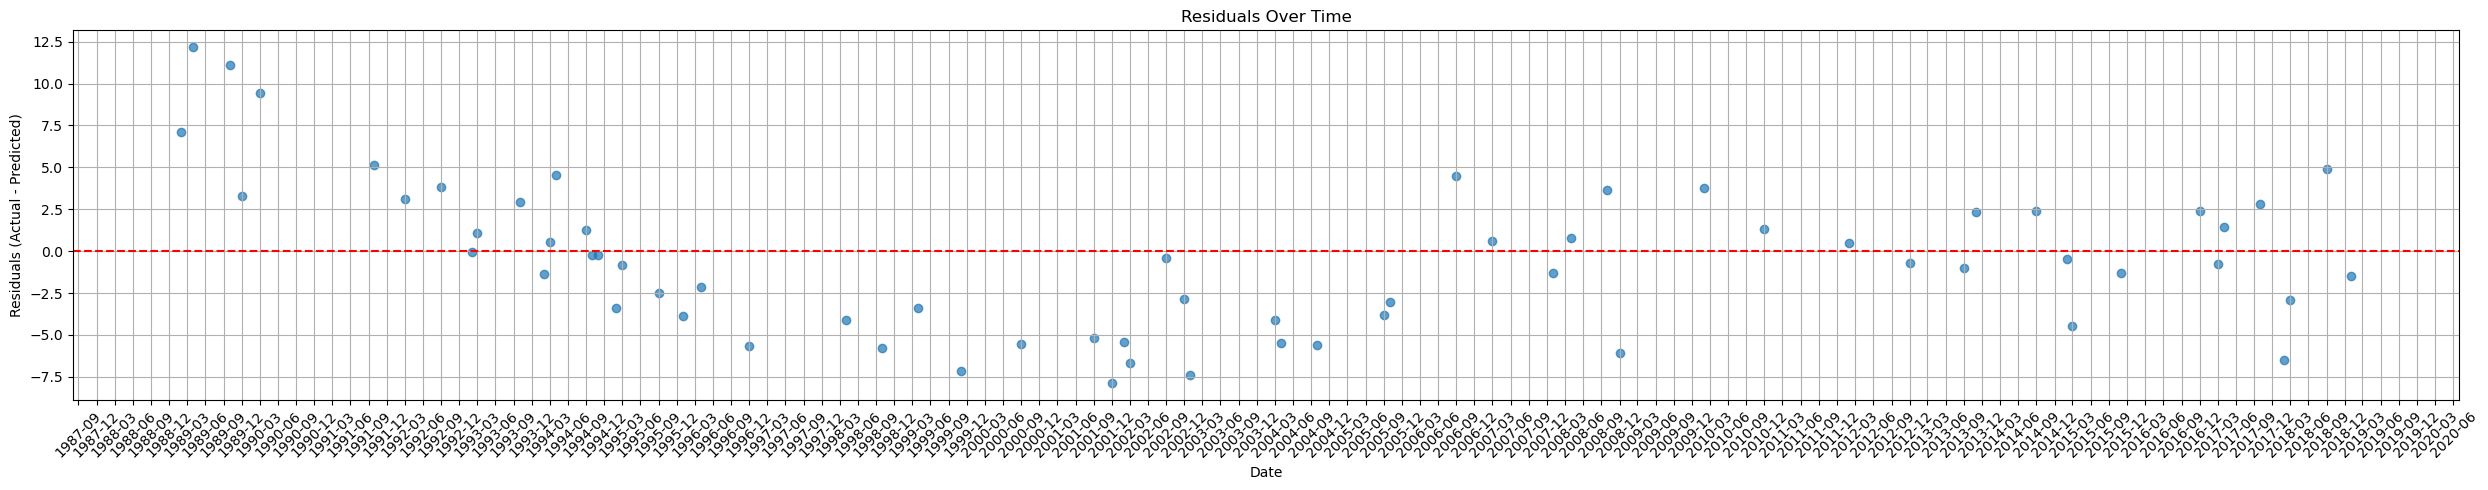

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

residuals = y_test_1 - y_pred

plt.figure(figsize=(25, 5))
plt.scatter(REF_DATE_test_1, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residuals (Actual - Predicted)")

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Periodic fluctuations: add dummies

From the graph, we can see that from 1987-09 to 1993-03, the residual is above 0 and shows a constant declining trend. From 1993-03 to 2005-12, we can observe that the residual is declining below 0 and stays steadily under 0. From 2006-01 onwards, the residual appears to be well-behaved, staying around 0 with no noticeable pattern.

Now, we have sufficient evidence that periodic fluctuations are present but not captured. To address this, I decided to create 3 periodic dummies to capture the fluctuations. I only used 2 of the dummies in the predictive model because the residual for the 3rd period looks normal.


In [41]:
df['dummy_p1'] = (
    (df['REF_DATE'] >= '1988-11-01') & (df['REF_DATE'] <= '1994-02-28')
).astype(int)
df['dummy_p2'] = (
    (df['REF_DATE'] >= '1994-03-01') & (df['REF_DATE'] <= '2005-11-30')
).astype(int)
df['dummy_p3'] = (
    (df['REF_DATE'] >= '2006-01-01') & (df['REF_DATE'] <= '2021-08-30')
).astype(int)

df



,REF_DATE,CPI,HINDEX,CREDIT,MRATE,HNUM,CNUM,URATE,TimeTrend,CPI_growth,CREDIT_growth,SubprimeCrisis,dummy_p1,dummy_p2,dummy_p3
394,1988-11-01,72.3,55.0,19.2308,11.78,8318.0,3844.0,10.2,1,0.1,0.2018,0,1,0,0
395,1988-12-01,72.3,55.8,19.4579,12.13,7249.0,2670.0,9.8,2,0.0,0.2271,0,1,0,0
396,1989-01-01,72.7,56.3,19.6837,12.24,5990.0,4667.0,11.3,3,0.4,0.2258,0,1,0,0
397,1989-02-01,73.2,57.7,19.9273,12.23,5024.0,2137.0,11.1,4,0.5,0.2436,0,1,0,0
398,1989-03-01,73.6,58.6,20.1617,12.41,6423.0,3310.0,11.0,5,0.4,0.2344,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,2020-01-01,136.8,103.4,164.0113,4.08,4000.0,2806.0,8.8,375,0.4,0.6015,0,0,0,1
769,2020-02-01,137.4,103.8,164.4740,4.08,4302.0,4021.0,8.9,376,0.6,0.4627,0,0,0,1
770,2020-03-01,136.6,104.1,165.2870,3.90,4655.0,4196.0,15.1,377,-0.8,0.8130,0,0,0,1
771,2020-04-01,135.7,104.1,166.2719,3.95,3603.0,5444.0,22.6,378,-0.9,0.9849,0,0,0,1


# OLS with Periodic Dummies: Does the Predictive Model Behave Better?


### Here we use OLS added Periodic Dummies to see if the residul scatter changed and if MSE decreased.

In [42]:
df0 = df.copy()
X = df0[[ 'CPI_growth','CREDIT_growth', 'HNUM','CNUM','URATE','dummy_p1','dummy_p2','TimeTrend']].values
y = df0['HINDEX'].values
features = [ 'CPI_growth','CREDIT_growth', 'HNUM','CNUM','URATE','dummy_p1','dummy_p2','TimeTrend']

REF_DATE = df['REF_DATE']  

X_train, X_test, y_train, y_test, REF_DATE_train, REF_DATE_test = train_test_split(
    X, y, REF_DATE, test_size=0.2, random_state=42
)

In [43]:
model_d = linear_model.LinearRegression()
model_d.fit(X_train, y_train)
coefficients = pd.Series(model_d.coef_, index=features)
print("Coefficients:\n", coefficients)
print("Intercept:", model_d.intercept_)
print("R-squared:", model_d.score(X_test, y_test))
y_pred_d= model_d.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred_d))
baseline_mse = np.mean((y_test - np.mean(y_train))**2)
print("Baseline MSE:", baseline_mse)

Coefficients:
 CPI_growth       -0.262790
CREDIT_growth     3.121465
HNUM             -0.000503
CNUM              0.000684
URATE            -0.429572
dummy_p1         -1.337454
dummy_p2        -11.230048
TimeTrend         0.115515
dtype: float64
Intercept: 61.346026542906884
R-squared: 0.983702000724869
MSE: 5.280973721032951
Baseline MSE: 331.49968113225685


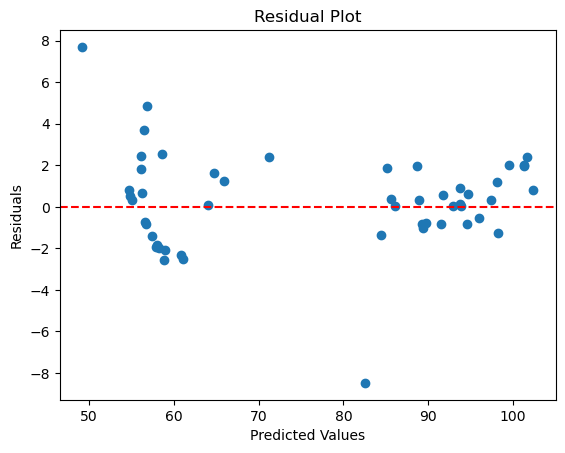

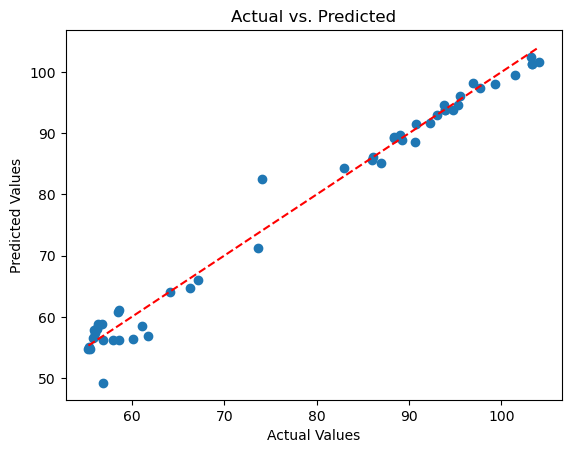

In [44]:
plt.scatter(y_pred_d, y_test - y_pred_d)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.show()

# 2. Actual vs. Predicted
plt.scatter(y_test, y_pred_d)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title("Actual vs. Predicted")
plt.show()

## Explanation of the Gap Between Values 70-80

I drew a graph to show a possible explanation for the gap between 70 and 80, which is shown below:

As we can see, the house price increased sharply between 2004 and 2008.

Especially, it took a very short time for the price to increase from 70 to 80.

This means that the time interval (between the two red lines) is very short. Therefore, the data points for the index values between 70 and 80 are few. This is the reason for the gap shown in the residual plot and the Actual vs. Predicted plot, which is normal.

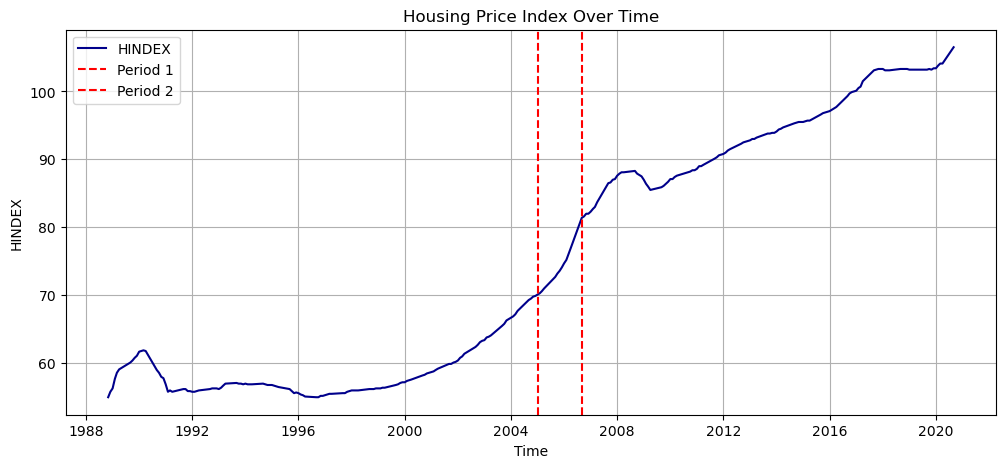

In [45]:
plt.figure(figsize=(12, 5))
plt.plot(df["REF_DATE"], df["HINDEX"], label="HINDEX", color="darkblue")
plt.title("Housing Price Index Over Time")
plt.xlabel("Time")
plt.ylabel("HINDEX")

# Add red vertical lines at specific time points (convert the string to datetime)
plt.axvline(x=pd.to_datetime("2005-01-01"), color="red", linestyle="--", label="Period 1")
plt.axvline(x=pd.to_datetime("2006-9-01"), color="red", linestyle="--", label="Period 2")

plt.grid(True)
plt.legend()
plt.show()

plt.show()




### Lasso

In [46]:
from sklearn.linear_model import Lasso

In [47]:
lasso_model = Lasso(alpha=0.1, max_iter=10000)
lasso_model.fit(X_train, y_train)
coefficients = pd.Series(lasso_model.coef_, index=features)
print("Coefficients:\n", coefficients)
print("Intercept:", lasso_model.intercept_)
print("R-squared:", lasso_model.score(X_test, y_test))
y_pred_lasso = lasso_model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred_lasso))
print("Baseline MSE:", baseline_mse)



Coefficients:
 CPI_growth       -0.000000
CREDIT_growth     0.112343
HNUM             -0.000473
CNUM              0.000809
URATE            -0.381590
dummy_p1          0.000000
dummy_p2        -10.356742
TimeTrend         0.124297
dtype: float64
Intercept: 59.079617554682684
R-squared: 0.9826772902803413
MSE: 5.6130064348566595
Baseline MSE: 331.49968113225685


In [48]:
mse_scores = cross_val_score(lasso_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(lasso_model,X_train, y_train, cv=10, scoring='r2')

# Print results
print("Cross-validated MSE (negative):", mse_scores)
print("Mean Cross-validated MSE:", -np.mean(mse_scores)) 
print("Cross-validated R-squared:", r2_scores)
print("Mean Cross-validated R-squared:", np.mean(r2_scores))


Cross-validated MSE (negative): [ -4.79334115  -4.43262534  -6.40441535  -7.75712378  -7.67878015
  -6.37539297 -10.28491659  -2.34693814  -3.67896448  -4.92293073]
Mean Cross-validated MSE: 5.867542868120666
Cross-validated R-squared: [0.98141695 0.985804   0.9774101  0.975076   0.97763743 0.97699783
 0.97283774 0.99322971 0.98935866 0.98302446]
Mean Cross-validated R-squared: 0.9812792883674202


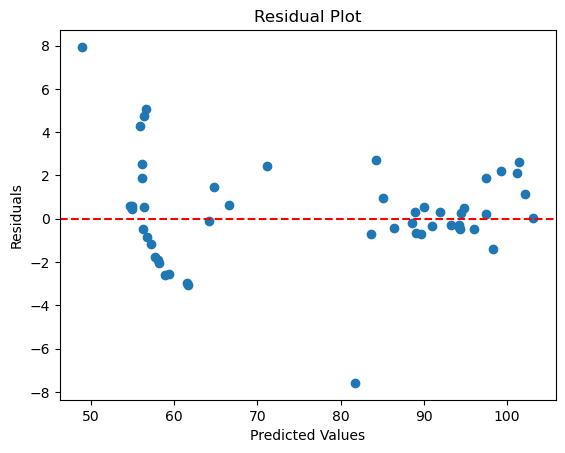

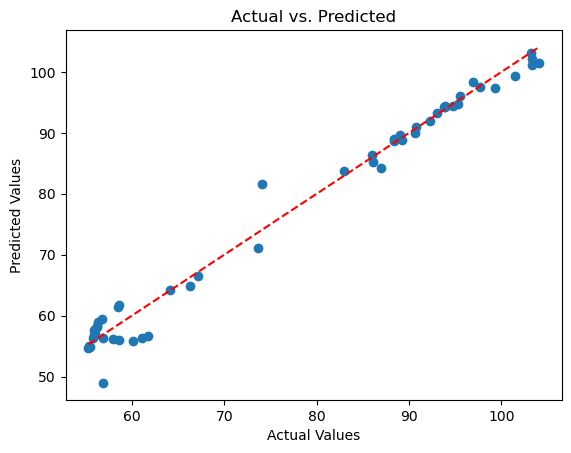

In [49]:
plt.scatter(y_pred_lasso, y_test -y_pred_lasso)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.show()

# 2. Actual vs. Predicted
plt.scatter(y_test, y_pred_lasso)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title("Actual vs. Predicted")
plt.show()

In [50]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [51]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train 
mlp = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=10000, random_state=42)
mlp.fit(X_train_scaled, y_train)

# predict 
y_pred_neu = mlp.predict(X_test_scaled)

#  mean squared error
model_mse = mean_squared_error(y_test,y_pred_neu)
print("Model MSE:", model_mse)


print("Baseline MSE:", baseline_mse)

# compare with baseline MSE
improvement = baseline_mse - model_mse
print("Improvement over baseline:", improvement)

Model MSE: 14.14023386045167
Baseline MSE: 331.49968113225685
Improvement over baseline: 317.3594472718052


In [52]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(32, 16),
        max_iter=100000,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=1000,
        random_state=42
    ))
])

# cross-validation
cv_scores_neu = cross_val_score(pipeline, X, y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# output
print("Cross-Validation MSE:", -cv_scores_neu)
print("Mean CV MSE:", -np.mean(cv_scores_neu))  
print("Standard Deviation of CV MSE:", np.std(cv_scores_neu))

Cross-Validation MSE: [13.23102976  5.23417499  5.33464945 23.53220332  5.73330441 17.8233312
  4.4863414   1.89229966  1.08053684 36.71314318]
Mean CV MSE: 11.506101421243653
Standard Deviation of CV MSE: 10.88139939833421


In [53]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(32, 16),
        max_iter=100000,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=1000,
        random_state=42
    ))
])

# cross-validation
cv_scores_neu = cross_val_score(pipeline, X_1, y_1, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# output
print("Cross-Validation MSE:", -cv_scores_neu)
print("Mean CV MSE:", -np.mean(cv_scores_neu))  
print("Standard Deviation of CV MSE:", np.std(cv_scores_neu))

Cross-Validation MSE: [13.4320798   1.46587617  0.36202679 16.34956438  8.33680523  5.65708832
 33.59578658  2.1810071   1.01838738 75.74348832]
Mean CV MSE: 15.814211006574771
Standard Deviation of CV MSE: 22.18595942264297


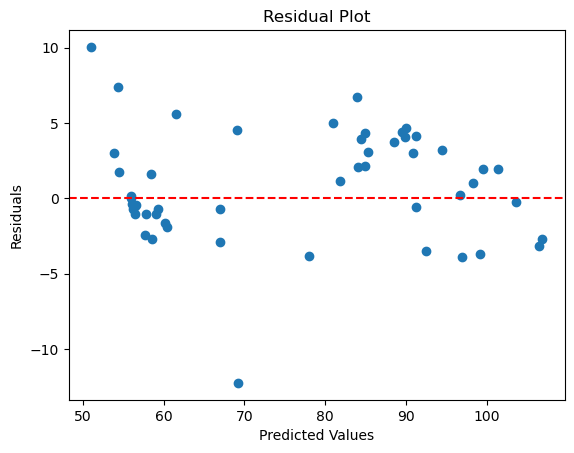

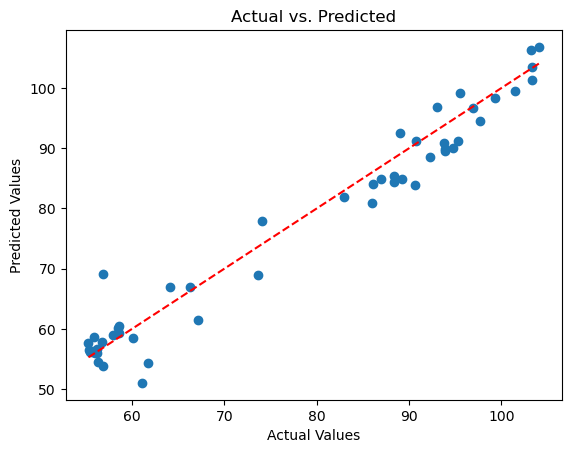

In [54]:
# 1. Residual Plot
plt.scatter(y_pred_neu, y_test - y_pred_neu)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.show()

# 2. Actual vs. Predicted
plt.scatter(y_test, y_pred_neu)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title("Actual vs. Predicted")
plt.show()

In [55]:
from sklearn.tree import DecisionTreeRegressor

In [56]:
tree = DecisionTreeRegressor(max_depth=4, random_state=0)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

print("Decision Tree R^2:", r2_score(y_test, y_pred_tree))
print("Decision Tree MSE:", mean_squared_error(y_test, y_pred_tree))

Decision Tree R^2: 0.9958280913251679
Decision Tree MSE: 1.351806421537637


In [57]:
pipeline = Pipeline([
    ('tree', DecisionTreeRegressor(
        max_depth=5,         
        min_samples_leaf=5,  
        random_state=42
    ))
])

# Cross-validation:
cv_scores_tree = cross_val_score(pipeline, X, y, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)

# Output 
print("Cross-Validation MSE:", -cv_scores_tree)
print("Mean CV MSE:", -np.mean(cv_scores_tree))
print("Standard Deviation of CV MSE:", np.std(cv_scores_tree))

Cross-Validation MSE: [ 7.89141132  1.42221245  1.75866107  6.40663077 13.7961094  19.21464842
  3.98672     4.90358889 10.12906939 11.00145625]
Mean CV MSE: 8.051050796553552
Standard Deviation of CV MSE: 5.323018256081229


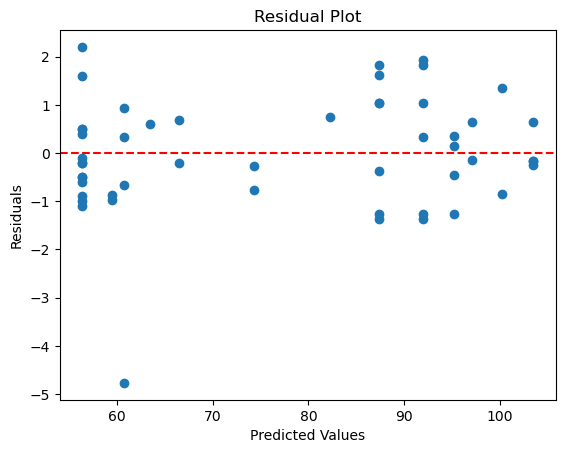

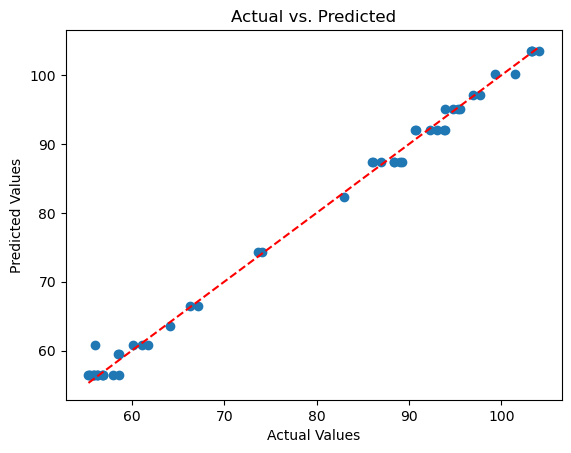

In [58]:
plt.scatter(y_pred_tree, y_test - y_pred_tree)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.show()

# 2. Actual vs. Predicted
plt.scatter(y_test, y_pred_tree)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title("Actual vs. Predicted")
plt.show()

# Limitation and discussion

### Use of CPI in Explaining Housing Prices

Including the Consumer Price Index (CPI) in a housing price model raises an important modeling choice. On the one hand, CPI includes housing-related costs such as mortgage interest, utilities, and property taxes—components that are clearly tied to the cost of living. However, these expenses can also move with housing prices, especially mortgage interest costs, which may rise when home values go up or interest rates change. This opens the door to potential endogeneity: if housing prices influence CPI and we use CPI to explain housing prices, we risk creating a feedback loop that biases our estimates.

It's important to note that CPI does not directly capture housing asset prices. Unlike housing price indices like HINDEX, which reflect changes in the market value of homes, CPI focuses on the recurring expenses of living in a home. For this reason, using CPI can still be useful—it gives us a way to account for broader inflationary pressure and economic conditions that likely influence the housing market.

Although the CPI includes housing-related expenditures (such as mortgage interest costs and property taxes), it does not directly reflect housing asset prices. Including CPI as a regressor allows us to capture the effect of broader living costs and inflationary pressure on housing price dynamics. However, we remain cautious of potential endogeneity due to overlapping channels and test the robustness of our results accordingly.

Looking ahead, future research might consider using core CPI (which excludes shelter) or disaggregating CPI components to focus on non-housing inflation. This could reduce the risk of bias while keeping the benefits of capturing inflationary trends in the economy.


## Appendix
GPT is used: https://chatgpt.com/share/68194ba3-f870-8000-9022-364f2a6f1639